## Generating expert trajectories

### Environment Setup - Predator-Prey

Custom 2-agent grid world using Gymnasium.

*Features*:

Grid size: 3x3

A1 starts at (0,0), A2 starts at (0,2).

Goals: A1 reach goal at (2,2), A2 catch A1

Actions: [UP, DOWN, LEFT, RIGHT] (4 actions per agent).

Observations: Positions of both agents.

Rewards:
- if A1 reaches goal, +10 for A1 -10 for A2
- if A2 catches A1, +10 for A2 -10 for A1

Agents moving simultaneously, game ends as soon as A1 reaches the goal OR A2 catches A1

In [67]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

grid_size = 3
max_steps = 100

class GridGame1(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 4}

    def __init__(self):
        self.grid_size = grid_size
        self.max_steps = max_steps

        self.init_positions = [(0, 0), (0, 2)]  # A1 at (0,0), A2 at (0,2)
        self.goal_pos_a1 = (2, 2)  # A1's goal
        self.reset()

        self.action_space = spaces.MultiDiscrete([4, 4])
        self.observation_space = spaces.Dict({
            "agent1": spaces.Box(0, self.grid_size - 1, shape=(2,), dtype=int),
            "agent2": spaces.Box(0, self.grid_size - 1, shape=(2,), dtype=int)
        })

    def reset(self):
        self.agent1_pos, self.agent2_pos = self.init_positions
        self.steps = 0
        return self._get_obs(), {}

    def _get_obs(self):
        return {
            "agent1": np.array(self.agent1_pos),
            "agent2": np.array(self.agent2_pos)
        }

    def step(self, actions):
        self.steps += 1
    
        # Move agents
        new_pos1 = self._move(self.agent1_pos, actions[0])
        new_pos2 = self._move(self.agent2_pos, actions[1])
    
        self.agent1_pos = new_pos1
        self.agent2_pos = new_pos2
    
        done = False
        reward1 = -1
        reward2 = +1
    
        if self.agent1_pos == self.agent2_pos:
            # A2 catches A1 — including the goal cell
            reward1 = -10
            reward2 = 10
            done = True
    
        elif self.agent1_pos == self.goal_pos_a1:
            # A1 reaches goal safely (not a catch)
            reward1 = 10
            reward2 = -10
            done = True
    
        done = done or self.steps >= self.max_steps
    
        return self._get_obs(), (reward1, reward2), done, {}, {}


    def _move(self, pos, action):
        x, y = pos
        if action == 0:  # UP
            x = max(0, x - 1)
        elif action == 1:  # DOWN
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # LEFT
            y = max(0, y - 1)
        elif action == 3:  # RIGHT
            y = min(self.grid_size - 1, y + 1)
        return (x, y)

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), '·', dtype='<U5')

        # Mark goal for A1
        gx, gy = self.goal_pos_a1
        grid[gx, gy] = 'G1'

        # Mark agents
        a1x, a1y = self.agent1_pos
        a2x, a2y = self.agent2_pos

        if self.agent1_pos == self.agent2_pos:
            grid[a1x, a1y] = 'A*'
        else:
            grid[a1x, a1y] = 'A1'
            grid[a2x, a2y] = 'A2'

        print("Current State:")
        for row in grid:
            print(" ".join(f"{cell:^5}" for cell in row))
        print()


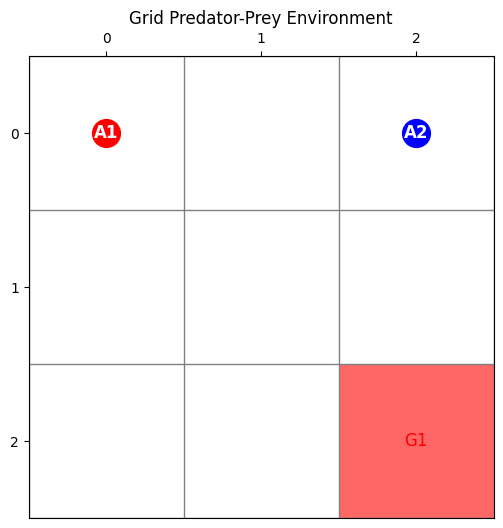

In [68]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_env_state(env):
    fig, ax = plt.subplots(figsize=(6, 6))

    # 1) Draw grid lines
    for x in range(env.grid_size + 1):
        ax.axvline(x, color='gray', linestyle='-', linewidth=1)
    for y in range(env.grid_size + 1):
        ax.axhline(y, color='gray', linestyle='-', linewidth=1)

    # 2) Set axis limits and ticks
    ax.set_xlim(0, env.grid_size)
    ax.set_ylim(0, env.grid_size)
    ax.set_xticks([i + 0.5 for i in range(env.grid_size)])
    ax.set_yticks([i + 0.5 for i in range(env.grid_size)])
    ax.set_xticklabels([str(i) for i in range(env.grid_size)])
    ax.set_yticklabels([str(i) for i in range(env.grid_size)])

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.invert_yaxis()
    ax.set_title("Grid Predator-Prey Environment")

    # Helpers
    def cell_coords(row, col):
        return (col, row)

    def center_coords(row, col):
        return (col + 0.5, row + 0.5)

    # 3) Highlight A1’s goal at (2, 2)
    gx, gy = env.goal_pos_a1
    ax.add_patch(patches.Rectangle(cell_coords(gx, gy), 1, 1, facecolor='red', alpha=0.6))
    ax.text(*center_coords(gx, gy), "G1", ha='center', va='center', fontsize=12, color='red')

    # 4) Plot agents
    a1_row, a1_col = env.agent1_pos
    a2_row, a2_col = env.agent2_pos

    if (a1_row, a1_col) == (a2_row, a2_col):
        ax.plot(*center_coords(a1_row, a1_col), 'purple', marker='o', markersize=20)
        ax.text(*center_coords(a1_row, a1_col), "A1&A2", fontsize=10, ha='center', va='center', color='white', fontweight='bold')
    else:
        ax.plot(*center_coords(a1_row, a1_col), 'ro', markersize=20)
        ax.text(*center_coords(a1_row, a1_col), "A1", fontsize=12, ha='center', va='center', color='white', fontweight='bold')

        ax.plot(*center_coords(a2_row, a2_col), 'bo', markersize=20)
        ax.text(*center_coords(a2_row, a2_col), "A2", fontsize=12, ha='center', va='center', color='white', fontweight='bold')

    plt.show()


env = GridGame1()
env.reset()
plot_env_state(env)


### Nash Q-Learning

In [69]:
import numpy as np
from nashpy import Game
import matplotlib.pyplot as plt

class NashQLearner:
    def __init__(self, env, alpha=0.1, gamma=0.99, epsilon=0.5, min_epsilon=0.01, decay_rate=0.0005):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.epsilon_history = []

        self.grid_size = env.grid_size
        # Q1 and Q2: [a1_x, a1_y, a2_x, a2_y, a1_action, a2_action]
        self.Q1 = np.zeros((self.grid_size, self.grid_size, self.grid_size, self.grid_size, 4, 4))
        self.Q2 = np.zeros((self.grid_size, self.grid_size, self.grid_size, self.grid_size, 4, 4))

    def decay_epsilon(self, episode):
        self.epsilon = max(self.min_epsilon, self.epsilon * 0.995)
        self.epsilon_history.append(self.epsilon)

    def get_action(self, state, explore=True):
        s = self._state_to_index(state)

        game = Game(self.Q1[s], self.Q2[s])
        equilibria = list(game.support_enumeration())

        if not equilibria or (explore and np.random.rand() < self.epsilon):
            return np.random.randint(0, 4), np.random.randint(0, 4)

        pi1, pi2 = equilibria[np.random.randint(len(equilibria))]  # Pick first Nash
        a1 = np.random.choice(4, p=pi1)
        a2 = np.random.choice(4, p=pi2)
        return a1, a2

    def update(self, state, actions, rewards, next_state):
        s = self._state_to_index(state)
        s_next = self._state_to_index(next_state)
        a1, a2 = actions
        r1, r2 = rewards

        game_next = Game(self.Q1[s_next], self.Q2[s_next])
        equilibria_next = list(game_next.support_enumeration())

        if not equilibria_next:
            nash_q1 = 0
            nash_q2 = 0
        else:
            pi1_next, pi2_next = equilibria_next[0]

            # Entropy regularization
            entropy1 = -np.sum(pi1_next * np.log(pi1_next + 1e-8))
            entropy2 = -np.sum(pi2_next * np.log(pi2_next + 1e-8))

            nash_q1 = np.sum(np.outer(pi1_next, pi2_next) * self.Q1[s_next]) + 0.05 * entropy1
            nash_q2 = np.sum(np.outer(pi1_next, pi2_next) * self.Q2[s_next]) + 0.05 * entropy2

        # TD target update with smoothing
        td1 = r1 + self.gamma * nash_q1
        td2 = r2 + self.gamma * nash_q2

        self.Q1[s][a1][a2] = (1 - self.alpha) * self.Q1[s][a1][a2] + self.alpha * td1
        self.Q2[s][a1][a2] = (1 - self.alpha) * self.Q2[s][a1][a2] + self.alpha * td2

        # Clip Q-values to avoid instability
        self.Q1[s][a1][a2] = np.clip(self.Q1[s][a1][a2], -50, 50)
        self.Q2[s][a1][a2] = np.clip(self.Q2[s][a1][a2], -50, 50)


    def _state_to_index(self, state):
        """Convert observation dict to discrete Q-table index."""
        return (
            state["agent1"][0], state["agent1"][1],
            state["agent2"][0], state["agent2"][1]
        )

    def plot_learning_curve(self, episode_rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(len(episode_rewards)), [r[0] for r in episode_rewards], label="Agent 1 (Prey)")
        plt.plot(np.arange(len(episode_rewards)), [r[1] for r in episode_rewards], label="Agent 2 (Predator)")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Learning Curve - Predator-Prey")
        plt.legend()
        plt.grid(True)
        plt.show()


##### Training Loop

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (16) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (12) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (8) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 000 | Avg Reward - Prey (A1): -14.00 | Predator (A2): 14.00


c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (4) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 010 | Avg Reward - Prey (A1): -10.40 | Predator (A2): 10.40


c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (6) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


Episode 020 | Avg Reward - Prey (A1): -12.10 | Predator (A2): 12.10
Episode 030 | Avg Reward - Prey (A1): -12.80 | Predator (A2): 12.80
Episode 040 | Avg Reward - Prey (A1): -8.60 | Predator (A2): 8.60
Episode 050 | Avg Reward - Prey (A1): -13.00 | Predator (A2): 13.00
Episode 060 | Avg Reward - Prey (A1): -5.60 | Predator (A2): 5.60
Episode 070 | Avg Reward - Prey (A1): -15.70 | Predator (A2): 15.70
Episode 080 | Avg Reward - Prey (A1): -5.00 | Predator (A2): 5.00
Episode 090 | Avg Reward - Prey (A1): -3.80 | Predator (A2): 3.80
Episode 100 | Avg Reward - Prey (A1): -2.50 | Predator (A2): 2.50
Episode 110 | Avg Reward - Prey (A1): -7.60 | Predator (A2): 7.60
Episode 120 | Avg Reward - Prey (A1): -4.10 | Predator (A2): 4.10
Episode 130 | Avg Reward - Prey (A1): 1.00 | Predator (A2): -1.00
Episode 140 | Avg Reward - Prey (A1): -11.00 | Predator (A2): 11.00
Episode 150 | Avg Reward - Prey (A1): -4.50 | Predator (A2): 4.50
Episode 160 | Avg Reward - Prey (A1): -0.40 | Predator (A2): 0.40


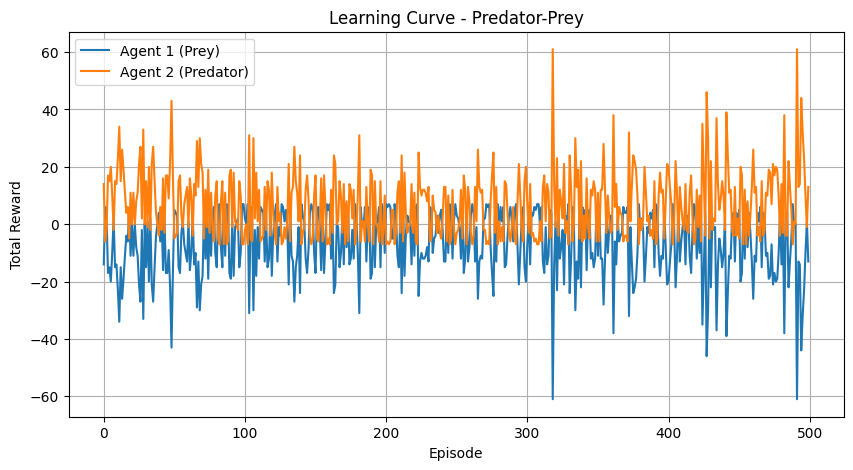

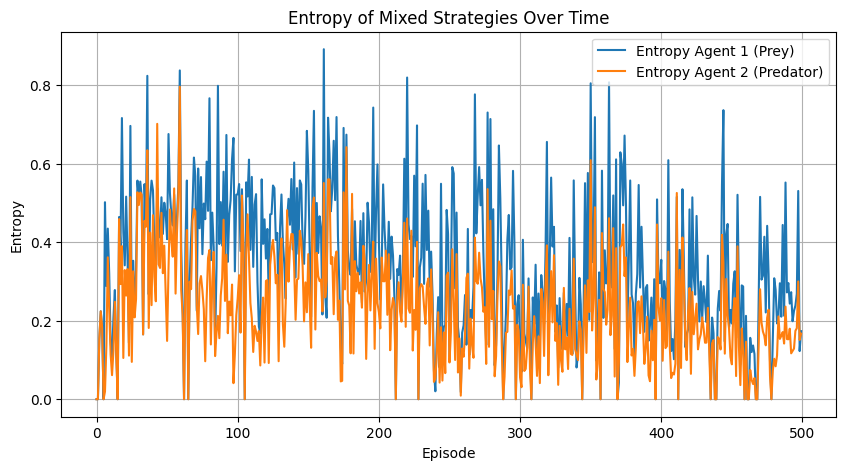

In [70]:
env = GridGame1()
agent = NashQLearner(env, alpha=0.05, gamma=0.99, epsilon=0.5)

all_episode_rewards = []
epsilon_decay = []
entropy_log = []
nash_gap_log = []
nash_gap_over_time = []
n_episodes = 500

# Track fixed states to compute Nash gap over time
tracked_states = []
while len(tracked_states) < 10:
    a1 = (np.random.randint(env.grid_size), np.random.randint(env.grid_size))
    a2 = (np.random.randint(env.grid_size), np.random.randint(env.grid_size))
    if a1 != a2:
        tracked_states.append((a1[0], a1[1], a2[0], a2[1]))

# Function to compute average Nash gap across tracked states
def compute_avg_gap(agent, tracked_states):
    gaps = []
    for s in tracked_states:
        Q1_s = agent.Q1[s]
        Q2_s = agent.Q2[s]
        game = Game(Q1_s, Q2_s)
        equilibria = list(game.support_enumeration())
        if not equilibria:
            continue
        pi1, pi2 = equilibria[0]
        br1 = np.max(Q1_s @ pi2)
        v1 = np.sum(pi1 * (Q1_s @ pi2))
        gap1 = br1 - v1
        br2 = np.max(Q2_s.T @ pi1)
        v2 = np.sum(pi2 * (Q2_s.T @ pi1))
        gap2 = br2 - v2
        gaps.append(max(gap1, gap2))
    return np.mean(gaps) if gaps else 0.0

for episode in range(n_episodes):
    state, _ = env.reset()
    done = False
    total_reward = [0, 0]
    entropies_episode = []

    while not done:
        actions = agent.get_action(state)
        next_state, rewards, terminated, truncated, _ = env.step(actions)
        done = terminated or truncated

        agent.update(state, actions, rewards, next_state)

        # Entropy tracking
        s = agent._state_to_index(state)
        game = Game(agent.Q1[s], agent.Q2[s])
        equilibria = list(game.support_enumeration())

        if equilibria:
            pi1, pi2 = equilibria[0]
            entropy1 = -np.sum(pi1 * np.log(pi1 + 1e-8))
            entropy2 = -np.sum(pi2 * np.log(pi2 + 1e-8))
        else:
            entropy1 = entropy2 = 0

        entropies_episode.append((entropy1, entropy2))

        state = next_state
        total_reward[0] += rewards[0]
        total_reward[1] += rewards[1]

    avg_entropy = np.mean(entropies_episode, axis=0) if entropies_episode else (0, 0)
    entropy_log.append(avg_entropy)

    # Compute and log average Nash gap across tracked states
    nash_gap = compute_avg_gap(agent, tracked_states)
    nash_gap_over_time.append(nash_gap)

    all_episode_rewards.append(total_reward)
    agent.decay_epsilon(episode)
    epsilon_decay.append(agent.epsilon)

    if episode % 10 == 0:
        avg_rewards = np.mean(all_episode_rewards[-10:], axis=0)
        print(f"Episode {episode:03d} | Avg Reward - Prey (A1): {avg_rewards[0]:.2f} | Predator (A2): {avg_rewards[1]:.2f}")

# Plot reward learning curve
agent.plot_learning_curve(all_episode_rewards)

# Plot entropy
def plot_entropy(entropy_log):
    e1 = [e[0] for e in entropy_log]
    e2 = [e[1] for e in entropy_log]
    plt.figure(figsize=(10, 5))
    plt.plot(e1, label="Entropy Agent 1 (Prey)")
    plt.plot(e2, label="Entropy Agent 2 (Predator)")
    plt.xlabel("Episode")
    plt.ylabel("Entropy")
    plt.title("Entropy of Mixed Strategies Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_entropy(entropy_log)



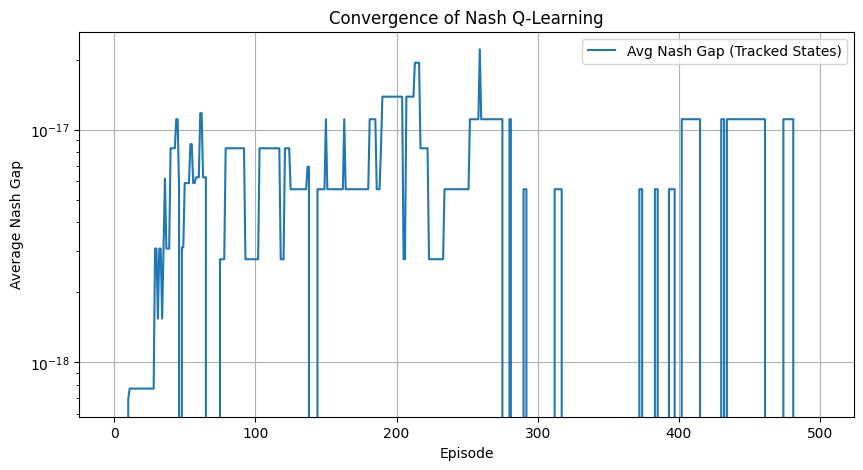

In [71]:
# Plot Nash gap over time
plt.figure(figsize=(10, 5))
plt.plot(nash_gap_over_time, label="Avg Nash Gap (Tracked States)")
plt.xlabel("Episode")
plt.ylabel("Average Nash Gap")
plt.title("Convergence of Nash Q-Learning")
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

### Plotting

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_q_values(agent, agent_id=1, state=(1, 1, 1, 1)):
    q_table = agent.Q1[state] if agent_id == 1 else agent.Q2[state]

    plt.figure(figsize=(8, 6))
    sns.heatmap(q_table, annot=True, fmt=".1f", cmap="viridis")

    action_names = ["UP", "DOWN", "LEFT", "RIGHT"]
    plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=action_names)

    plt.xlabel("Agent 2 Actions")
    plt.ylabel("Agent 1 Actions")
    title = f"Q-Values for {'Prey (A1)' if agent_id == 1 else 'Predator (A2)'} at State {state}"
    plt.title(title)
    plt.show()


def visualize_trajectory(agent, env):
    state, _ = env.reset()
    done = False
    trajectory1 = [state["agent1"]]
    trajectory2 = [state["agent2"]]

    while not done:
        actions = agent.get_action(state, explore=False)
        next_state, _, terminated, truncated, _ = env.step(actions)
    
        # Append only before potentially breaking
        trajectory1.append(next_state["agent1"])
        trajectory2.append(next_state["agent2"])
    
        done = terminated or truncated
        state = next_state

    plt.figure(figsize=(8, 8))

    def convert_2darray_coords(pos):
        return (pos[1], 2 - pos[0])  # Flip row index for display

    # Plot agent trajectories
    plt.plot(*zip(*[convert_2darray_coords(p) for p in trajectory1]),
             marker='o', label="Prey (A1)", color='blue')
    plt.plot(*zip(*[convert_2darray_coords(p) for p in trajectory2]),
             marker='s', label="Predator (A2)", color='red')

    # Plot goal for A1
    goal_coords = convert_2darray_coords(env.goal_pos_a1)
    plt.gca().add_patch(plt.Rectangle((goal_coords[0] - 0.5, goal_coords[1] - 0.5), 1, 1, color='lightgreen', alpha=0.3))
    plt.text(*goal_coords, "G1", fontsize=12, ha='center', va='center', color='green', fontweight='bold')

    # Plot initial positions
    init1 = convert_2darray_coords(env.init_positions[0])
    init2 = convert_2darray_coords(env.init_positions[1])
    plt.text(*init1, "A1", fontsize=12, ha='center', va='center', color='blue', fontweight='bold')
    plt.text(*init2, "A2", fontsize=12, ha='center', va='center', color='red', fontweight='bold')

    # Grid styling
    plt.xticks([0, 1, 2], ['0', '1', '2'])
    plt.yticks([0, 1, 2], ['2', '1', '0'])
    plt.grid(True)
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    plt.legend()
    plt.title("Predator-Prey Trajectories")
    plt.show()


def plot_exploration_decay(epsilon_decay):
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(epsilon_decay)), epsilon_decay)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Exploration Rate Decay")
    plt.grid(True)
    plt.show()


In [ ]:
visualize_trajectory(agent, env)
plot_exploration_decay(epsilon_decay)

<Figure size 800x800 with 0 Axes>

### Generating expert trajectories

In [191]:
def generate_nash_expert_data(agent, env, num_episodes=50):
    expert_data = {
        "prey": {"states": [], "actions": []},
        "predator": {"states": [], "actions": []}
    }

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False

        while not done:
            # Use deterministic Nash strategy
            actions = agent.get_action(obs, explore=False)
            
            # Record expert state-action pairs
            expert_data["prey"]["states"].append(obs["agent1"])
            expert_data["predator"]["states"].append(obs["agent2"])
            expert_data["prey"]["actions"].append(actions[0])
            expert_data["predator"]["actions"].append(actions[1])

            obs, _, terminated, truncated, _ = env.step(actions)
            done = terminated or truncated

    return expert_data


In [210]:
expert_data = generate_nash_expert_data(agent, env, num_episodes=200)

c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (0) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (2) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)
c:\Users\lents\anaconda3\lib\site-packages\nashpy\algorithms\support_enumeration.py:260: RuntimeWarning: 
An even number of (4) equilibria was returned. This
indicates that the game is degenerate. Consider using another algorithm
to investigate.
                  
  warnings.warn(warning, RuntimeWarning)


In [211]:
from collections import Counter

a1_choices = []
for _ in range(1000):
    obs, _ = env.reset()
    actions = agent.get_action(obs, explore=False)
    a1_choices.append(actions[0])

print(Counter(a1_choices))

Counter({1: 276, 2: 249, 3: 247, 0: 228})


## MAGAIL

In [212]:
def make_env():
    return GridGame1()

In [213]:
obs_dims = {
    "prey": 2,
    "predator": 2
}

act_dims = {
    "prey": 4,
    "predator": 4
}


### Discriminator

In [214]:
class Discriminator(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.net(x)


### Generator

In [215]:
class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, act_dim)
        )

    def forward(self, obs):
        logits = self.net(obs)
        return torch.distributions.Categorical(logits=logits)


### Training Loop

In [216]:
def train_multiagent_magail(env_fn, expert_data, num_epochs=1000, batch_size=64, lr=1e-3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    env = env_fn()

    # Set dimensions
    obs_dim = 2
    act_dim = 4

    # Initialize networks
    policy1 = Policy(obs_dim, act_dim).to(device)
    policy2 = Policy(obs_dim, act_dim).to(device)
    disc1 = Discriminator(obs_dim, act_dim).to(device)
    disc2 = Discriminator(obs_dim, act_dim).to(device)

    opt_policy1 = optim.Adam(policy1.parameters(), lr=lr)
    opt_policy2 = optim.Adam(policy2.parameters(), lr=lr)
    opt_disc1 = optim.Adam(disc1.parameters(), lr=lr)
    opt_disc2 = optim.Adam(disc2.parameters(), lr=lr)

    # Prepare expert tensors
    expert_obs1 = torch.tensor(expert_data["prey"]["states"], dtype=torch.float32).to(device)
    expert_act1 = torch.tensor(expert_data["prey"]["actions"], dtype=torch.long).to(device)

    expert_obs2 = torch.tensor(expert_data["predator"]["states"], dtype=torch.float32).to(device)
    expert_act2 = torch.tensor(expert_data["predator"]["actions"], dtype=torch.long).to(device)

    for epoch in range(num_epochs):
        obs, _ = env.reset()
        traj1_obs, traj1_act = [], []
        traj2_obs, traj2_act = [], []
        done = False

        while not done:
            o1 = torch.tensor(obs["agent1"], dtype=torch.float32).unsqueeze(0).to(device)
            o2 = torch.tensor(obs["agent2"], dtype=torch.float32).unsqueeze(0).to(device)

            a1 = policy1(o1).sample().item()
            a2 = policy2(o2).sample().item()

            traj1_obs.append(obs["agent1"])
            traj2_obs.append(obs["agent2"])
            traj1_act.append(a1)
            traj2_act.append(a2)

            obs, _, terminated, truncated, _ = env.step((a1, a2))
            done = terminated or truncated

        # Convert to tensors
        traj1_obs = torch.tensor(traj1_obs, dtype=torch.float32).to(device)
        traj1_act = torch.tensor(traj1_act, dtype=torch.long).to(device)
        traj2_obs = torch.tensor(traj2_obs, dtype=torch.float32).to(device)
        traj2_act = torch.tensor(traj2_act, dtype=torch.long).to(device)

        # Discriminator updates
        def update_disc(disc, expert_obs, expert_act, gen_obs, gen_act, optimizer):
            expert_in = torch.cat([expert_obs, nn.functional.one_hot(expert_act, act_dim).float()], dim=1)
            gen_in = torch.cat([gen_obs, nn.functional.one_hot(gen_act, act_dim).float()], dim=1)

            logits_e = disc(expert_obs, nn.functional.one_hot(expert_act, act_dim).float())
            logits_g = disc(gen_obs, nn.functional.one_hot(gen_act, act_dim).float())

            loss_e = -torch.log(torch.sigmoid(logits_e + 1e-8)).mean()
            loss_g = -torch.log(1 - torch.sigmoid(logits_g) + 1e-8).mean()
            loss = loss_e + loss_g

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return loss.item()

        loss_d1 = update_disc(disc1, expert_obs1, expert_act1, traj1_obs, traj1_act, opt_disc1)
        loss_d2 = update_disc(disc2, expert_obs2, expert_act2, traj2_obs, traj2_act, opt_disc2)

        # Policy updates (REINFORCE) 
        def update_policy(policy, disc, traj_obs, traj_act, optimizer):
            with torch.no_grad():
                logits = disc(traj_obs, nn.functional.one_hot(traj_act, act_dim).float())
                rewards = -torch.log(1 - torch.sigmoid(logits) + 1e-8).squeeze()

            dist = policy(traj_obs)
            log_probs = dist.log_prob(traj_act)
            loss = -torch.mean(log_probs * rewards)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return loss.item()

        loss_p1 = update_policy(policy1, disc1, traj1_obs, traj1_act, opt_policy1)
        loss_p2 = update_policy(policy2, disc2, traj2_obs, traj2_act, opt_policy2)

        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] D1: {loss_d1:.3f} | D2: {loss_d2:.3f} | P1: {loss_p1:.3f} | P2: {loss_p2:.3f}")

    return policy1, policy2


In [217]:
trained_policy1, trained_policy2 = train_multiagent_magail(
    env_fn=make_env,
    expert_data=expert_data,
    num_epochs=1000
)


[Epoch 0] D1: 1.429 | D2: 1.434 | P1: 0.821 | P2: 0.886
[Epoch 100] D1: 1.151 | D2: 0.959 | P1: 0.557 | P2: 0.599
[Epoch 200] D1: 0.917 | D2: 0.596 | P1: 0.264 | P2: 0.118
[Epoch 300] D1: 0.973 | D2: 0.728 | P1: 0.314 | P2: 0.247
[Epoch 400] D1: 1.441 | D2: 2.512 | P1: 1.066 | P2: 1.773
[Epoch 500] D1: 1.173 | D2: 1.387 | P1: 0.548 | P2: 0.527
[Epoch 600] D1: 1.103 | D2: 1.079 | P1: 0.440 | P2: 0.851
[Epoch 700] D1: 1.675 | D2: 1.301 | P1: 1.204 | P2: 0.705
[Epoch 800] D1: 1.359 | D2: 1.215 | P1: 0.702 | P2: 0.978
[Epoch 900] D1: 1.142 | D2: 1.091 | P1: 0.812 | P2: 0.772


### Evaluate Policy

In [218]:
def evaluate_multiagent_policy(policy1, policy2, env_fn, num_episodes=50):
    rewards_agent1 = []
    rewards_agent2 = []

    for _ in range(num_episodes):
        env = env_fn()
        obs, _ = env.reset()
        total1, total2 = 0, 0
        done = False

        while not done:
            device1 = next(policy1.parameters()).device
            device2 = next(policy2.parameters()).device

            obs1 = torch.tensor(obs["agent1"], dtype=torch.float32).unsqueeze(0).to(device1)
            obs2 = torch.tensor(obs["agent2"], dtype=torch.float32).unsqueeze(0).to(device2)

            action1 = policy1(obs1).sample().item()
            action2 = policy2(obs2).sample().item()

            obs, rewards, terminated, truncated, _ = env.step((action1, action2))
            total1 += rewards[0]
            total2 += rewards[1]
            done = terminated or truncated

        rewards_agent1.append(total1)
        rewards_agent2.append(total2)

    return np.mean(rewards_agent1), np.mean(rewards_agent2)


r1, r2 = evaluate_multiagent_policy(trained_policy1, trained_policy2, make_env)
print(f"Average Reward — Prey (A1): {r1:.2f}, Predator (A2): {r2:.2f}")


Average Reward — Prey (A1): -10.86, Predator (A2): 10.86


### Visualization

In [219]:
def visualize_magail_joint_trajectory(policy1, policy2, env):
    state, _ = env.reset()
    done = False
    trajectory1 = [state["agent1"]]
    trajectory2 = [state["agent2"]]

    while not done:
        device1 = next(policy1.parameters()).device
        device2 = next(policy2.parameters()).device

        obs1 = torch.tensor(obs["agent1"], dtype=torch.float32).unsqueeze(0).to(device1)
        obs2 = torch.tensor(obs["agent2"], dtype=torch.float32).unsqueeze(0).to(device2)
        
        action1 = policy1(obs1).sample().item()
        action2 = policy2(obs2).sample().item()

        next_state, _, terminated, truncated, _ = env.step((action1, action2))
        trajectory1.append(next_state["agent1"])
        trajectory2.append(next_state["agent2"])
        state = next_state
        done = terminated or truncated

    plt.figure(figsize=(8, 8))

    def convert(pos):
        return (pos[1], 2 - pos[0])  # Flip for display

    plt.plot(*zip(*[convert(p) for p in trajectory1]), marker='o', color='blue', label='Prey (A1)')
    plt.plot(*zip(*[convert(p) for p in trajectory2]), marker='s', color='red', label='Predator (A2)')

    # Goal
    goal = convert(env.goal_pos_a1)
    plt.gca().add_patch(plt.Rectangle((goal[0] - 0.5, goal[1] - 0.5), 1, 1, color='lightgreen', alpha=0.3))
    plt.text(*goal, "G1", fontsize=12, ha='center', va='center', color='green', fontweight='bold')

    # Initial positions
    init1 = convert(env.init_positions[0])
    init2 = convert(env.init_positions[1])
    plt.text(*init1, "A1", fontsize=12, ha='center', va='center', color='blue', fontweight='bold')
    plt.text(*init2, "A2", fontsize=12, ha='center', va='center', color='red', fontweight='bold')

    plt.xticks([0, 1, 2], ['0', '1', '2'])
    plt.yticks([0, 1, 2], ['2', '1', '0'])
    plt.grid(True)
    plt.xlim(-0.5, 2.5)
    plt.ylim(-0.5, 2.5)
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().xaxis.set_label_position('top')
    plt.legend()
    plt.title("Trajectories — MAGAIL Agents")
    plt.show()


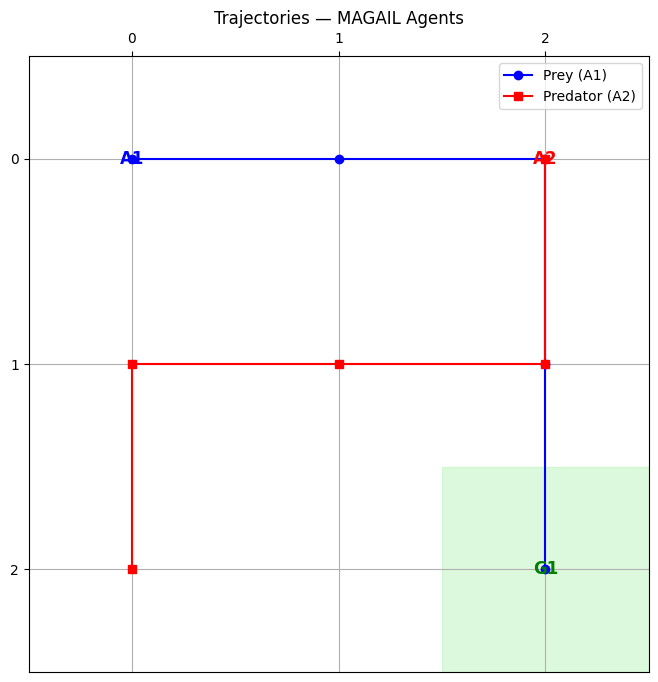

In [227]:
env = GridGame1()
visualize_magail_joint_trajectory(trained_policy1, trained_policy2, env)

### Measuring goal reaching/capture rates

In [233]:
def evaluate_success_and_capture(policy1, policy2, env_fn, num_episodes=100):
    success_count = 0  # Prey reaches goal
    capture_count = 0  # Predator catches prey
    timeout_count = 0  # Max steps without termination

    for _ in range(num_episodes):
        env = env_fn()
        obs, _ = env.reset()
        done = False

        while not done:
            device1 = next(policy1.parameters()).device
            device2 = next(policy2.parameters()).device

            obs1 = torch.tensor(obs["agent1"], dtype=torch.float32).unsqueeze(0).to(device1)
            obs2 = torch.tensor(obs["agent2"], dtype=torch.float32).unsqueeze(0).to(device2)

            action1 = policy1(obs1).sample().item()
            action2 = policy2(obs2).sample().item()

            obs, rewards, terminated, truncated, _ = env.step((action1, action2))
            done = terminated or truncated

            # Early termination check
            if done:
                if rewards[0] == 10:
                    success_count += 1
                elif rewards[0] == -10:
                    capture_count += 1
                elif truncated:
                    timeout_count += 1

    print(f"Out of {num_episodes} episodes:")
    print(f"Prey succeeded: {success_count} ({success_count / num_episodes:.2%})")
    print(f"Predator caught prey: {capture_count} ({capture_count / num_episodes:.2%})")
    print(f"Timeout (no termination): {timeout_count} ({timeout_count / num_episodes:.2%})")


evaluate_success_and_capture(trained_policy1, trained_policy2, GridGame1)


Out of 100 episodes:
Prey succeeded: 27 (27.00%)
Predator caught prey: 73 (73.00%)
Timeout (no termination): 0 (0.00%)
